In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install sentence-transformers

In [79]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
import nltk
from sklearn.model_selection import KFold
import os
import torch
import string
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from sentence_transformers import SentenceTransformer,LoggingHandler, InputExample, losses, util, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, TripletEvaluator
from torch.utils.data import DataLoader
from nltk.corpus  import stopwords
nltk.download('stopwords')
stopwords = stopwords.words("english")
stopwords = list(set(stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## reading the csv file

In [37]:
path_to_csv = "/content/drive/MyDrive/case_study/task_2/information_retreival/reddit_text-davinci-002.csv"
df = pd.read_csv(path_to_csv)

In [38]:

def preprocessing_step(data):
    data = re.sub(r"http\S+", '', data) # remove all the links which start with http
    data = re.sub(r"www\s+", "", data) # all the links if it's start with www
    # removing the punctuation
    data = data.translate(str.maketrans('', '',string.punctuation))
    # remove the stop words
    splitted_data = data.lower().split()
    filtered_data = list(filter(lambda x: x not in stopwords, splitted_data))
    data = " ".join(filtered_data)
    return data

df["anchor"] = df["prompt"].apply(preprocessing_step)
df["positive"] = df["completion"].apply(preprocessing_step)

# remove the columns
df.drop(columns=["prompt", "completion"], axis=1, inplace=True)

In [47]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(1522, 2)
(1522, 2)


Converting the dataset into the format **anchor, positive, negative**

In [54]:
# let's create a new dataset where we also add the negative anchor
new_df = pd.DataFrame(columns=["anchor", "positive","negative"])
for idx, rows in df.iterrows():
  all_positive_samples = df["positive"].values.tolist()
  all_positive_samples.remove(rows["positive"])
  sample_negative  = random.sample(all_positive_samples, 1)
  new_df.loc[idx] = [rows["anchor"], rows["positive"], sample_negative[0]]

new_df.head()

,anchor,positive,negative
0,father child dating year big argument first wa...,sounds like feeling alone unsupported right un...,youre feeling isolated expat sales director im...
1,cant seem feel emotion except anxiety even,possible experiencing symptoms anxiety disorde...,im sorry hear youre feeling stuck difficult fi...
2,allow one bad experiences felt worthless dicta...,possible explanations might allow bad experien...,sounds like still working lot pain past unders...
3,major depression severe ptsd anxiety disorder ...,understandable feeling upset given diagnosis d...,one answer question normalcy vary greatly coup...
4,need therapist,onesizefitsall answer question need therapist ...,sounds like need conversation husband feelings...


# Task Explanation.

* build the domain specific information retreival system, whose task is to provide for every query all the relevant answer.
* For this I am using the dataset with prompt and it's completion, so for example for every given prompt i will try to find the corresponding completion.
* I will be doing the finetuning of the sentence transformers model.

<p> Since we are using the dataset to finetune the sentence-transformers model, for this we need to convert the dataset into desired format epected by sentence transformers, model <p>

* Two different ways we can fine-tune the sentence-transformers model, for the information retrieval task.
    * One way is to use prompt --- completion as query & positive.
    * Another way is to create a new dataset with query, positive and negative.

* I will be using the approach second where i am adding the negative column.

#### K-fold cross validation

In [57]:
PATH_TO_SAVE_FOLDS = "/content/drive/MyDrive/case_study/task_2/information_retreival/preprocessed_dataset/"
kfold = KFold(n_splits=5)
for idx, (train_idx, test_idx) in enumerate(kfold.split(new_df)):
    fold_name = f"Fold_{idx}"
    path = os.path.join(PATH_TO_SAVE_FOLDS, fold_name)
    os.makedirs(path, exist_ok=True)

    train = new_df.iloc[train_idx]
    test   = new_df.iloc[test_idx]

    train.to_csv(path+"/train.csv", index=False)
    test.to_csv(path+"/test.csv", index=False)

## Strategy 1: (Query -- Positive -- Negative)

> MultipleNegativesRankingLoss: I am going to use this loss function, because this loss function is best when we have only positive pair, for example
query it's corresponding response.
* This Loss function take in input batch (a_i,b_i) which in our case is query and response. They assume that a_i and b_i is positive where as all the other value is considered negative for example if i = 10 so (a_10, b_10) is considered positive but any value of i which is not 10 is considered negative to this.
* It basically minimizes the negative-log-likehood.
* We can also provide one or multiple hard negatives per anchor-positive pair by structering the data like this: (a_1, p_1, n_1), (a_2, p_2, n_2). Then, n_1 is a hard negative for (a_1, p_1). The loss will use for the pair (a_i, p_i) all p_j for j != i and all n_j as negatives.

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [59]:
!rm -rf /content/drive/MyDrive/case_study/task_2/information_retreival/models

### Evaluation Metrics:

> Triplet Evaluation Framework
In the triplet evaluation framework, each evaluation instance (or triplet) consists of:

* Anchor: The query or anchor text for which relevant and non-relevant items are being retrieved.
* Positive: A relevant item that should be retrieved for the anchor.
* Negative: A non-relevant item that should not be retrieved for the anchor.

The goal of the model is to rank the positive item higher than the negative item based on their similarity to the anchor.

In this case i am calculating three type of metrics:
1. Accuracy_cosine:- consine distance between embeddings for both (anchor, positive) and (anchor, negative). Than we check if positive distance is less than negative distance.  
2. Accuracy_manhatten:- manhatten distance computed for both  positive, negative.
3. Accuracy_euclidien:- same as manhatten only formula changes.

In [61]:
# let's read the dataset
# the model we will use to finetune this dataset.
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.DEBUG, handlers=[LoggingHandler()]
)
PATH_TO_SAVE_FOLDS = "/content/drive/MyDrive/case_study/task_2/information_retreival/preprocessed_dataset/"
EPOCHS = 5
warmup_steps = 0
show_progress_bar=True
output_dir = "/content/drive/MyDrive/case_study/task_2/information_retreival/models/"
for i in range(5):
    print("**"*10, f" Fold_{i} ", "**"*10)
    bert = models.Transformer('bert-base-uncased')
    pooler = models.Pooling(
        bert.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True
    ) # convert the word embedding produced from bert model into single sentence embedding

    model = SentenceTransformer(modules=[bert, pooler]).to(device) # we can use much better model, but it's just for understanding purpose.

    fold_name = f"Fold_{i}"
    output_path = os.path.join(output_dir, fold_name)
    train_file = os.path.join(PATH_TO_SAVE_FOLDS, fold_name, "train.csv")
    test_file  = os.path.join(PATH_TO_SAVE_FOLDS, fold_name, "test.csv")
    # reading the dataset.
    train_dataset = pd.read_csv(train_file) # train
    test_dataset = pd.read_csv(test_file) #test
    train_dataset.dropna(inplace=True)
    test_dataset.dropna(inplace=True)

    # train examples
    train_examples = []
    for idx, rows in train_dataset.iterrows():
        train_examples.append(InputExample(texts=[rows["anchor"],rows["positive"], rows["negative"]]))

    # test examples
    test_examples = []
    for idx, rows in test_dataset.iterrows():
      test_examples.append(InputExample(texts=[rows["anchor"],rows["positive"], rows["negative"]]))

    test_evaluator = TripletEvaluator.from_input_examples(test_examples, batch_size=16, name="test")
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16, drop_last=True)
    logging.info("  Num examples = %d", len(train_examples))
    logging.info("  Batch size = %d", train_dataloader.batch_size)
    warmup_steps = int(len(train_dataloader) * EPOCHS * 0.1)
    # loss function
    train_loss = losses.MultipleNegativesRankingLoss(model)
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=EPOCHS,
        optimizer_params={"lr": 2e-5},
        warmup_steps=warmup_steps,
        evaluator=test_evaluator,
        evaluation_steps=int((len(test_examples)/16*EPOCHS)/30),
        show_progress_bar=show_progress_bar,
        save_best_model=True,
        output_path=output_path,
        checkpoint_save_total_limit=2,
    )


********************  Fold_0  ********************


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]

********************  Fold_1  ********************


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

********************  Fold_2  ********************


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

********************  Fold_3  ********************


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

********************  Fold_4  ********************


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

# Plot the metrics.

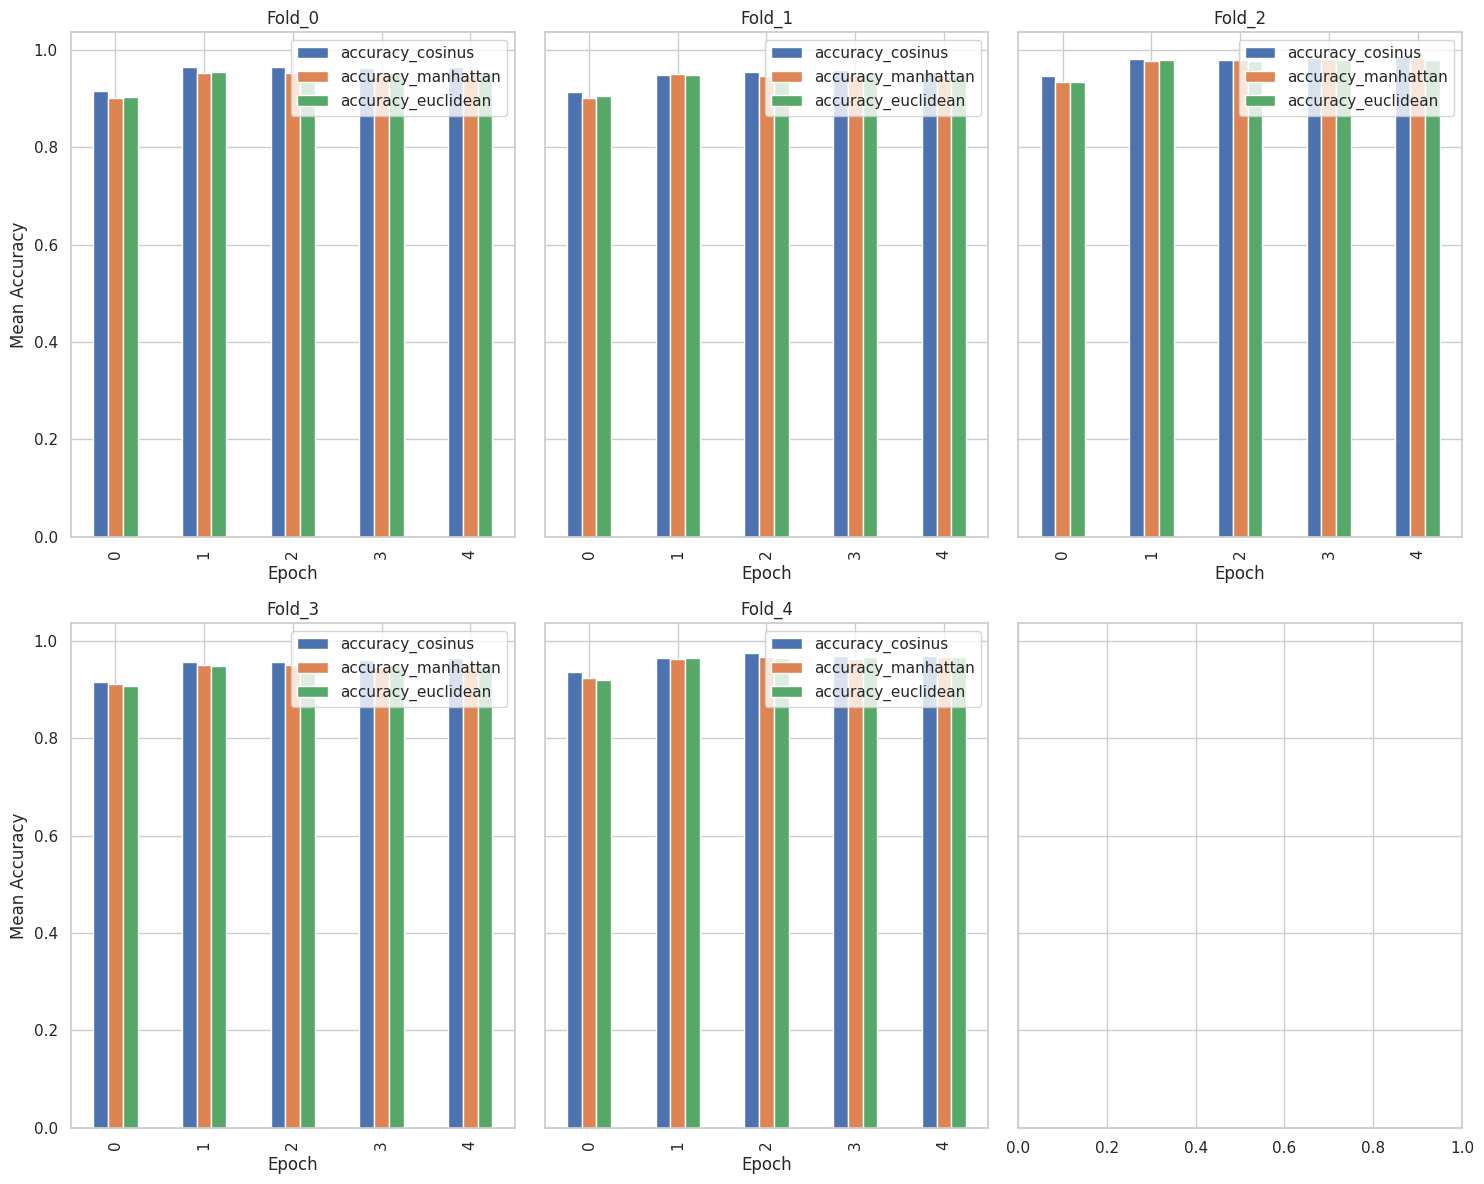

In [107]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12), sharey=True)
axs = axs.ravel()

for i in range(5):
    fold_name = f"Fold_{i}"
    output_path = os.path.join(output_dir, fold_name, "eval")

    # Read the CSV file
    df_metrics = pd.read_csv(os.path.join(output_path, os.listdir(output_path)[0]))

    # Calculate average accuracy for each epoch
    df_avg_metrics = df_metrics.groupby("epoch")[["accuracy_cosinus", "accuracy_manhattan", "accuracy_euclidean"]].mean()
    df_avg_metrics.reset_index(inplace=True)

    # Plot on the i-th subplot
    df_avg_metrics.plot(x='epoch', kind="bar", ax=axs[i], legend=True)
    axs[i].set_title(f"Fold_{i}")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Mean Accuracy")

# Adjust layout
plt.tight_layout()
plt.show()

#  Test the model performance on Fold 2 which seems to perform the best.

In [136]:
# loading the model
model_path="/content/drive/MyDrive/case_study/task_2/information_retreival/models/Fold_2"
model = SentenceTransformer(model_path)

In [137]:
test_dataset = pd.read_csv("/content/drive/MyDrive/case_study/task_2/information_retreival/preprocessed_dataset/Fold_2/test.csv")
test_dataset.head()

,anchor,positive,negative
0,past week boyfriend fighting making lot bad ch...,tough care someone making bad choices feel lik...,7 want happy
1,hotline worker told bad personliar hung,dispatched police job next day,easy answer comes infidelity possible overcome...
2,maybe stupid question sometimes dont know what...,theres easy answer question unfortunately some...,im sorry hear youre feeling alone lost youd li...
3,grandsons stepmother sends school pink barbie ...,appropriate punish child making carry backpack...,onesizefitsall answer question best way get li...
4,whenever run situation makes upset angry tend ...,sounds like bit temper get upset angry tend la...,easy answer question difficult let go past tra...


### Give a query find the mapping of positive.

In [159]:
corpus =test_dataset["positive"].values.tolist()
test_embeddings = model.encode(corpus)

In [160]:
random_index = random.sample(range(len(test_dataset)), 1)[0]
print("---"*10," Query ", "---"*10)
print(test_dataset["anchor"][random_index])
print("---"*10," Positive GT ", "---"*10)
print(test_dataset["positive"][random_index])
print("---"*10," Negative GT ", "---"*10)
print(test_dataset["negative"][random_index])

query_embedding = model.encode(test_dataset["anchor"][random_index])
output = util.semantic_search(query_embedding, test_embeddings, top_k=5)
print("---"*10, " Top 5 ","---"*10)

for out in output:
  counter =0
  for val in out:
    print(f"-- {counter}")
    print(corpus[val["corpus_id"]])
    counter +=1

------------------------------  Query  ------------------------------
cope distress mum died dad got diagnosed cancer
------------------------------  Positive GT  ------------------------------
easy answer question grief process different everyone people find comfort talking friends family others find solace nature hobbies people find writing painting helps express emotions others find exercise helps release builtup tension ultimately need find works best order cope distress
------------------------------  Negative GT  ------------------------------
things could going possible husband simply interested sex also possible hes experiencing sort sexual dysfunction thats making difficult perform youre page committed working issue together number resources help youre feeling rejected frustrated important communicate husband way thats respectful understanding may helpful see therapist counselor together help navigate issue
------------------------------  Top 5  ------------------------------


### Give a positive find the mapping of query.

In [161]:
corpus =test_dataset["anchor"].values.tolist()
test_embeddings = model.encode(corpus)

In [164]:
random_index = random.sample(range(len(test_dataset)), 1)[0]
print("---"*10," Query(Positive) ", "---"*10)
print(test_dataset["positive"][random_index])
print("---"*10," Anchor ", "---"*10)
print(test_dataset["anchor"][random_index])

query_embedding = model.encode(test_dataset["positive"][random_index])
output = util.semantic_search(query_embedding, test_embeddings, top_k=5)
print("---"*10, " Top 5 ","---"*10)

for out in output:
  counter =0
  for val in out:
    print(f"-- {counter}")
    print(corpus[val["corpus_id"]])
    counter +=1

------------------------------  Query(Positive)  ------------------------------
number things contribute difficulty sleeping helpful talk doctor therapist explore potential causes solutions meantime things may help sleep better avoid caffeine stimulants evening establish regular sleep schedule create relaxing bedtime routine
------------------------------  Anchor  ------------------------------
iv strugling sleeping since 7 years old
------------------------------  Top 5  ------------------------------
-- 0
sleepless nights bad dreams
-- 1
need help ever want sleep
-- 2
ive strugling sleeping since 7 years old
-- 3
fall asleep cant help sit walk around
-- 4
iv strugling sleeping since 7 years old
